# Pre-processing


In [1]:
!pip install kneed #installing kneed library

In [2]:
import pandas as pd  #importing pandas for handling dataframes
import numpy as np   #importing numpy for mathematical calculations
from scipy import stats  #importing stats which is used for outlier detection
import seaborn as sns  #sns is used for ploting data
#StandardScalar is used to standardize the data
from sklearn.preprocessing import StandardScaler
#PCA is used to do PCA analysis
from sklearn.decomposition import PCA
#matplotlib helps with ploting figures
import matplotlib.pyplot as plt
#kneew is used to find in finding the right k value in elbow method
from kneed import KneeLocator
#KMeans is used to perform KMeans clustering
from sklearn.cluster import KMeans
#silhouette_score is used to calculate silhouette score
from sklearn.metrics import silhouette_score
#from sklearn.metrics import adjusted_rand_score
#shc is used to draw the dendrogram
import scipy.cluster.hierarchy as shc
#AgglomerativeClustering is used to perform Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
#times helps with finding the time taken to do stuff
import time
#shc is used to draw the dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

The shape of original data is:  (1763, 18) 

There are no missing/null values 

Shape of data after pre-processing (1593, 14) 

The heatmap showing the correlation between the features


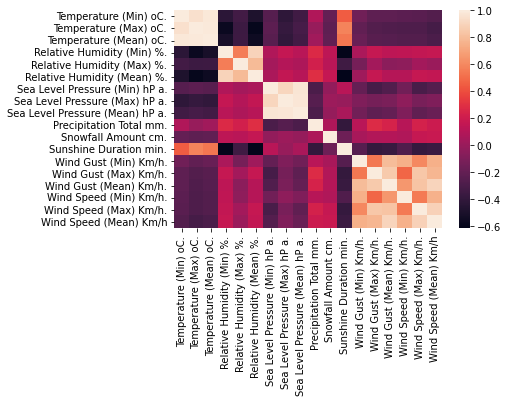

In [3]:
#importing the data.
df = pd.read_csv("/content/drive/MyDrive/CW2_data")
#printing the shape of the original data.
print("The shape of original data is: ", df.shape, "\n")

#checks if there are any null values in the data
if (df.isnull().values.any() == True):    
  print("There are missing/null values \n")
else:
  print("There are no missing/null values \n")

#removes outliers
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

#checks if there are any features that are correlated hence we drop them
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix)

#we compare the correlation between features and remove one of two 
#features that have a correlation higher than 0.9
columns = np.full((correlation_matrix.shape[0],), True, dtype=bool)  #create a 
                                                #numpy array with .full function
for i in range(correlation_matrix.shape[0]): 
    for j in range(i+1, correlation_matrix.shape[0]):
        if correlation_matrix.iloc[i,j] >= 0.9:       
            if columns[j]:
                columns[j] = False        
selected_columns = df.columns[columns]
#some features are droped
df = df[selected_columns]

#now we standardize the data
scalar = StandardScaler()
scale = scalar.fit_transform(df)

df = pd.DataFrame(scale, columns = selected_columns)
#we check the shape of the data after preprocessing.
#we observe the observation and features have both reduced
print("Shape of data after pre-processing", df.shape, "\n")

print("The heatmap showing the correlation between the features")

# PCA

Shape of PCA data is:  (1593, 4) 



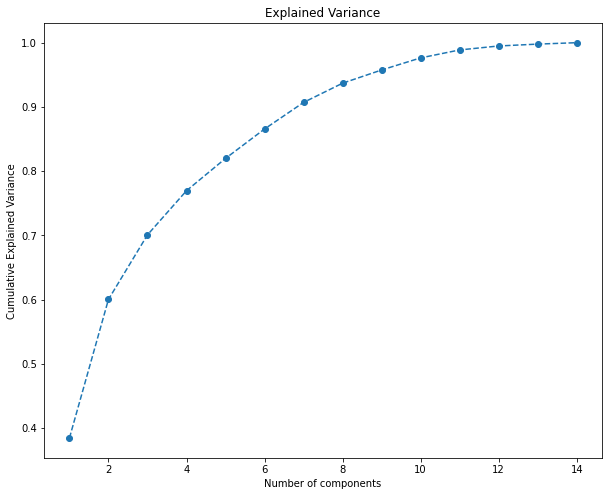

In [4]:
#we pass the standardized data to do PCA
pca = PCA()
pca.fit(df)

#graph explaining the number of components that should be choosen.
plt.figure(figsize = (10, 8))
plt.plot(range(1,15), pca.explained_variance_ratio_.cumsum(), marker = "o", linestyle = "--")
plt.title("Explained Variance")
plt.xlabel("Number of components")
plt.ylabel("Cumulative Explained Variance")

#from the graph we chose to take 4 principle components
pca = PCA(n_components=4)
pca.fit(df)

scores_pca = pca.transform(df)

#we get a new dataframe with four principle componenets.
pca_df = pd.DataFrame(scores_pca, columns = ["PCA 1", "PCA 2", "PCA 3", "PCA 4"])
print("Shape of PCA data is: ", pca_df.shape, "\n")

# Clustering

In [5]:
#A single class is created to perform all of the clustering tasks.
class clustering:
  #class takes in two imputs which are the data and the name of the data
  #name of the data must be df or pca_df
  def __init__(self, data, name):
    self.data = data
    self.name = name
    self.elbow_value = 0

  #kplot is a function which plots the kmeans clusters based on which data 
  #was passed.
  def kplot(self, model):
    if self.name == "df":
      plt.figure(figsize=(10, 7))
      #we have randomly taken two features to show the clustering.
      plt.scatter(df['Relative Humidity (Mean) %.'], df['Wind Gust (Mean) Km/h.'], c = model.labels_)
      plt.xlabel("Relative Humidity (Mean) %.")
      plt.ylabel("Wind Gust (Mean) Km/h.")
      plt.show()
    elif self.name == "pca_df":
      plt.figure(figsize=(10, 7))  
      plt.scatter(pca_df['PCA 1'], pca_df['PCA 2'], c=model.labels_)
      plt.xlabel("PCA 1")
      plt.ylabel("PCA 2")
      plt.show()
    else:
      print("the name must be df or pca_df")

  #aplot function is used to plot the dendrogram.
  def aplot(self):
    den = dendrogram(linkage(self.data, method='ward'), labels = self.data.index)
    plt.ylabel('Euclidean Distance', fontsize = 14)
    plt.title('Dendrogram')
    plt.show()

  #kclustering is the function which does the entire clustering task of kmeans
  def kclustering(self):
    start = time.time()
    #first we have just created a model without passing the number of clusters.
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42
    }
    
    #we then train the kmeans model based on the above hyperparameters.
    #we do this for all k values.
    sse = []
    for k in range(1,11):
      kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
      kmeans.fit(self.data)
      sse.append(kmeans.inertia_)

    pass
    end = time.time()
    delta = end - start
    print("took %.2f seconds to run kmeans for finding the no. of clusters." % delta)

    #we then plot the elbow curve to find out the ideal k value
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1,11))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.show()

    print("\n")
    
    #KneeLocator finds out the ideal k, hence we dont have to rely of plot.
    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
    print("The number of clusters we should choose are: ", kl.elbow, "\n")
    self.elbow_value = kl.elbow
    start = time.time()

    #here we train the model again with the obtained clusters.
    kmeans = KMeans(
        init = "random",
        n_clusters = kl.elbow,
        n_init = 10,
        max_iter = 1000,
        random_state = 42
    )

    kmeans.fit(self.data)

    pass
    end = time.time()
    delta = end - start
    print("took %.2f seconds to train the final kmeans model" % delta, "\n")

    print("The inertia of k-means is: ", kmeans.inertia_, "\n")

    print("The cluster centers are: ", kmeans.cluster_centers_, "\n")

    print("Iteration are: ",kmeans.n_iter_, "\n") 

    u_labels = np.unique(kmeans.labels_)

    #we then find out the silhouette score to see how well our clustering was.
    kmeans_sil = silhouette_score(
        self.data, kmeans.labels_
    ).round(2)

    print("Silhouette score of KMeans clustering is: ", kmeans_sil, "\n")

    #then we create a new column in our dataset to store the assigned labels
    #during the clustering.
    self.data["kmeans_labels"] = kmeans.fit_predict(self.data)
    print(self.data.head())

    #the kplot function is called to plot the clusters.
    self.kplot(kmeans)

    return (self.data, kmeans)

  def AggloCluster(self):
    #here we plot the dendrogram by calling the aplot function.
    self.aplot()

    start = time.time()
    
    #the second model of Agglomerative clustering is trained here.
    #based on the dendrogram, the number of clusters is chosen as 3
    agglo_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
    agglo_cluster.fit(self.data)

    pass
    end = time.time()
    delta = end - start
    print("took %.2f seconds to train the Agglomerative Model" % delta)

    #silhouette score is calculated to see how the clustering performed.
    hi_sil = silhouette_score(
        self.data, agglo_cluster.labels_
    ).round(2)

    print("Silhouette score of Agglomerative clustering is: ", hi_sil, "\n")

    #then we create a new column in our dataset to store the assigned labels
    #during the clustering
    self.data["hi_labels"] = agglo_cluster.fit_predict(self.data)
    
    #the plot of clusters is draws to show the clusters.
    self.kplot(agglo_cluster)

    return self.data, agglo_cluster


In [6]:
#the class clustering is called by passing different data.
c1 = clustering(df, "df")
c2 = clustering(pca_df, "pca_df")

took 2.98 seconds to run kmeans for finding the no. of clusters.


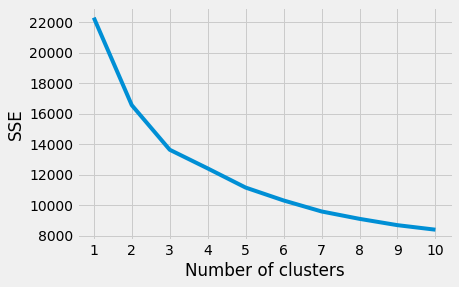



The number of clusters we should choose are:  3 

took 0.07 seconds to train the final kmeans model 

The inertia of k-means is:  13638.232100128394 

The cluster centers are:  [[ 0.7109357  -0.79802912 -0.62150353 -0.86046706 -0.0306768  -0.29715382
  -0.15857569  0.78586772 -0.31761281 -0.45077722 -0.43330094 -0.36307951
  -0.44672609 -0.45885456]
 [-0.47706395  0.35824412  0.00772653  0.29599948 -0.57795254  0.49640749
   0.23854279 -0.7024147   1.33572388  1.36552023  1.53921938  1.26641419
   1.37514966  1.52879079]
 [-0.53272768  0.69219717  0.68325189  0.7943314   0.34108421  0.0648211
   0.04860319 -0.4958353  -0.35861259 -0.22717353 -0.33881522 -0.27149312
  -0.23677154 -0.30501159]] 

Iteration are:  24 

Silhouette score of KMeans clustering is:  0.22 

   Temperature (Min) oC.  ...  kmeans_labels
0              -0.130203  ...              2
1               0.256479  ...              2
2               0.154991  ...              2
3               0.171692  ...              

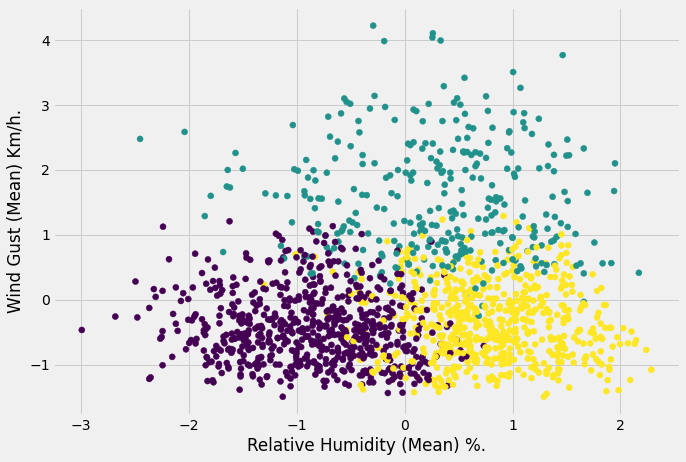

In [7]:
#functions are called to get the whole clustering report.
df, kmeans1 = c1.kclustering()

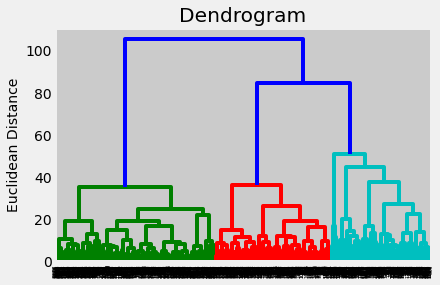

took 0.09 seconds to train the Agglomerative Model
Silhouette score of Agglomerative clustering is:  0.24 



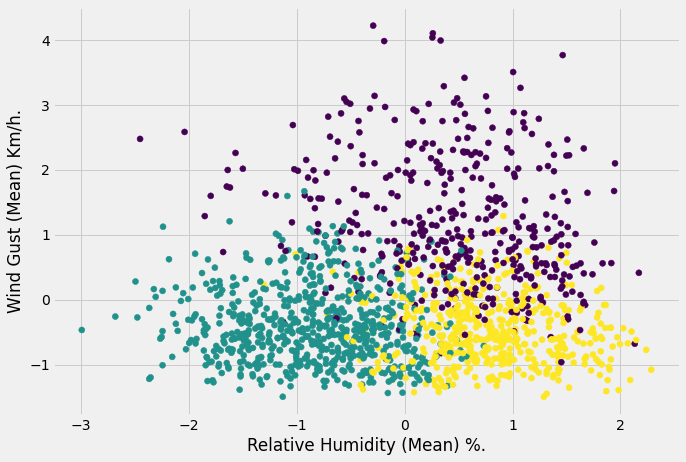

In [8]:
df, agglocluster1 = c1.AggloCluster() 

took 3.00 seconds to run kmeans for finding the no. of clusters.


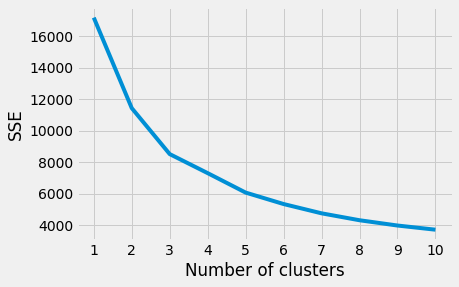



The number of clusters we should choose are:  3 

took 0.07 seconds to train the final kmeans model 

The inertia of k-means is:  8512.998290713906 

The cluster centers are:  [[-1.6354841   1.17466589  0.13722484  0.11301595]
 [-0.1927893  -1.65216022 -0.14108691 -0.09780948]
 [ 3.50065746  0.64966907 -0.01584428 -0.04553855]] 

Iteration are:  10 

Silhouette score of KMeans clustering is:  0.32 

      PCA 1     PCA 2     PCA 3     PCA 4  kmeans_labels
0 -0.366665 -1.537246  0.191969 -0.242692              1
1  0.916037 -0.774239  0.451457 -0.377895              1
2  0.105587 -2.318669  0.229629 -0.479374              1
3 -1.670480 -0.756103 -0.013046 -0.046441              1
4 -3.018150  0.042882  0.082406  0.153040              0


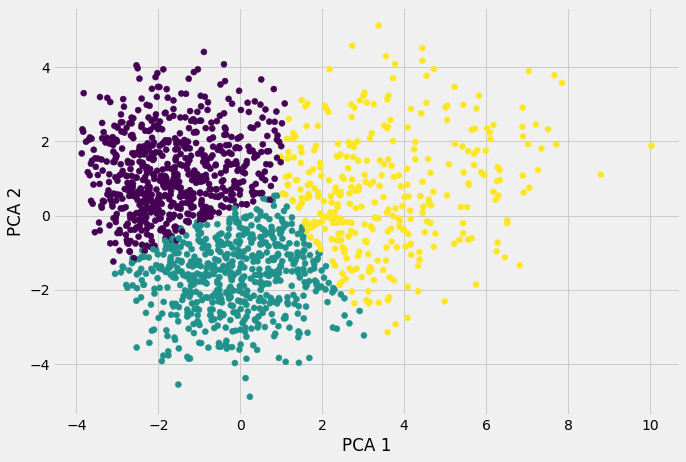

In [9]:
pca_df, kmeans2 = c2.kclustering()

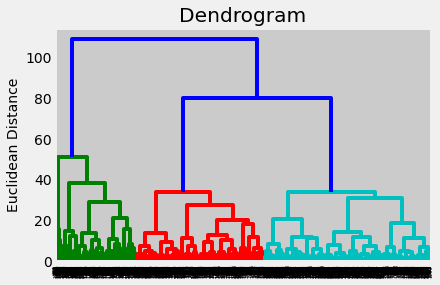

took 0.09 seconds to train the Agglomerative Model
Silhouette score of Agglomerative clustering is:  0.32 



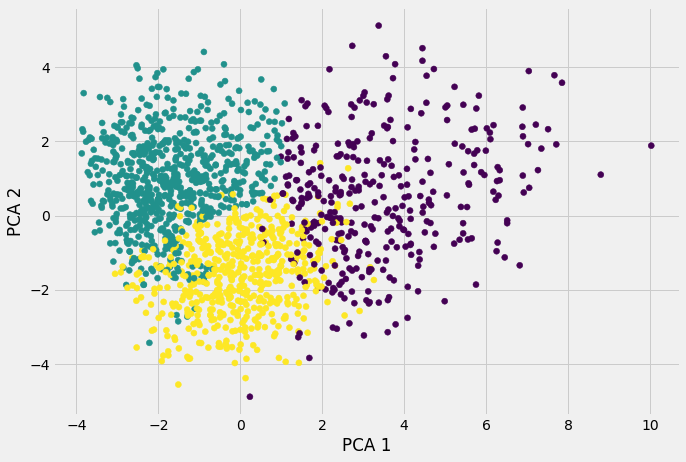

In [10]:
pca_df, agglocluster2 = c2.AggloCluster()

# Classification

In [11]:
import pandas as pd
#train test split is used to split the data in to training and testing sets.
from sklearn.model_selection import train_test_split
#logistic regression is used to perform logistic regression
from sklearn.linear_model import LogisticRegression
#metrics is used to evalute the performance of models
from sklearn import metrics
#confusion matrix is use to show the confusion matrix for the model.
from sklearn.metrics import confusion_matrix
import time
#classification report gives the entire report of the classification.
#showing values like accuracy, precision, recall, f1-score.
from sklearn.metrics import classification_report
#cross_val_score is used to perform and calculate the cross validation
from sklearn.model_selection import cross_val_score
#svm is used to used to perform svm models
from sklearn import svm
#roc_auc_score is used to find the auc score and while plotting the roc curve
from sklearn.metrics import roc_auc_score
#lgm is used to perform gradient boosting.
import lightgbm as lgb
#accuracy_score show the accuracy of the model.
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [12]:
#importing the data.
df = pd.read_csv("/content/drive/MyDrive/data2")
df.shape

labels = pd.read_csv("/content/drive/MyDrive/labels")
labels.shape

#checking if there are any null values in the data.
df.isnull().sum()

#combining the two data.
data2 = pd.concat([df, labels], axis=1)  
#removing the first 16 features to balance the data. 
data2 = data2.tail(172)

#see if the data is balanced
data2["Labels"].value_counts() 

#data is shuffled
data2 = data2.sample(frac=1, random_state=10).reset_index(drop=True) 

#the labels are converted from 1 and 2 to 0 and 1 respectively
data2["Labels"].replace({1: 0, 2: 1}, inplace=True)

#the shape of the final data is checked.
print("The shape of data is: ", data2.shape)

#since the data was small all the three features were kept.

The shape of data is:  (172, 4)


In [13]:
#we now allocate the feature from the second data which WLA to X
X = data2.iloc[:,0:3]       
y = data2["Labels"]         #we allocate the labels to y

#we now perform train test split which can be used to train and 
#test the models in the future.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, shuffle=True) 

print("Train Features: ",X_train.shape, "Test Features: ", X_test.shape, "Train Labels: ", y_train.shape, "Test Labels: ", y_test.shape)

Train Features:  (137, 3) Test Features:  (35, 3) Train Labels:  (137,) Test Labels:  (35,)


In [14]:
#a classification class is created to perform all the classification tasks.
class classification:
  # it takes in the all the features and the splited data.
  def __init__(self, X, y, X_train, X_test, y_train, y_test):
    self.X = X
    self.y = y
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

  #evaluate function is defined to evaluate the various parameters.
  #to see how well the models have performed.
  def evaluate(self, y_pred, model):
    #prints the accuracy.
    print("Accuracy: ", round(metrics.accuracy_score(self.y_test, y_pred), 2), "\n")

    #prints precision.
    print("Precision: ", round(metrics.precision_score(self.y_test, y_pred), 2), "\n")

    #prints recal.
    print("Recall: ", round(metrics.recall_score(self.y_test, y_pred), 2), "\n")

    #prints f1 score.
    print("f1 score: ", round(metrics.f1_score(self.y_test, y_pred), 2), "\n")
    
    #cprints the confusion matrix
    matrix = confusion_matrix(self.y_test, y_pred)
    print("Confusion Matrix is: \n", matrix, "\n")

    #prints cross validation score
    cross_val = cross_val_score(model, self.X, self.y, cv=10, scoring='roc_auc').mean()
    print("Cross validation score is: ", round(cross_val, 2), "\n")

    #prints the classification report
    print(classification_report(self.y_test, y_pred), "\n")

  #logistic_Regressing function gives out the logistic regression report.
  def logistic_Regressing(self):
    start = time.time()

    #a losgistic regression model is trained
    logreg = LogisticRegression()
    logreg.fit(self.X_train, self.y_train)

    #once the model is created, prediction is done on the test data.
    y_pred = logreg.predict(self.X_test)
    
    pass
    end = time.time()
    delta = end - start
    print("took %.2f seconds to train the Logistic Regression Model " % delta)
    
    #once prediction are done we check the performance of model.
    #the predicted values and model is passed to evaluate function.
    self.evaluate(y_pred, logreg)

    #roc curve is plotted.
    self.plot_roc(y_pred)

  #SVM function gives out the svm report.
  def SVM(self):
    start = time.time()

    #a svm model is trained
    svm_model = svm.SVC(kernel='sigmoid')
    svm_model.fit(self.X_train, self.y_train)
    
    #once the model is created, prediction is done on the test data.
    y_pred = svm_model.predict(self.X_test)

    pass
    end = time.time()
    delta = end - start
    print("took %.2f seconds to train SVM Model" % delta)

    #once prediction are done we check the performance of model.
    #the predicted values and model is passed to evaluate function.
    self.evaluate(y_pred, svm_model)
    
    #roc curve is plotted.
    self.plot_roc(y_pred)
  
  #LGBM function gives out the gradient boosting report.
  def LGBM(self):
    start = time.time()

    #a gradient boosting model is trained
    lgbm_model = lgb.LGBMClassifier()
    lgbm_model.fit(self.X_train, self.y_train)

    #once the model is created, prediction is done on the test data.
    y_pred=lgbm_model.predict(self.X_test)

    pass
    end = time.time()
    delta = end - start
    print("took %.2f seconds to train LightGBM Model" % delta)

    #once prediction are done we check the performance of model.
    #the predicted values and model is passed to evaluate function.
    self.evaluate(y_pred, lgbm_model)
    
    #roc curve is plotted.
    self.plot_roc(y_pred)
  
  #this function plots a roc curve for each model. 
  def plot_roc(self, y_pred):
    plt.figure(0).clf()
    fpr, tpr, thresh = metrics.roc_curve(self.y_test, y_pred)
    auc = metrics.roc_auc_score(self.y_test, y_pred)
    plt.plot(fpr,tpr,label="data , auc="+str(auc))
    plt.legend(loc=0)

Logistic Regression Report 

took 0.10 seconds to train the Logistic Regression Model 
Accuracy:  0.97 

Precision:  0.94 

Recall:  1.0 

f1 score:  0.97 

Confusion Matrix is: 
 [[18  1]
 [ 0 16]] 

Cross validation score is:  1.0 

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.94      1.00      0.97        16

    accuracy                           0.97        35
   macro avg       0.97      0.97      0.97        35
weighted avg       0.97      0.97      0.97        35
 



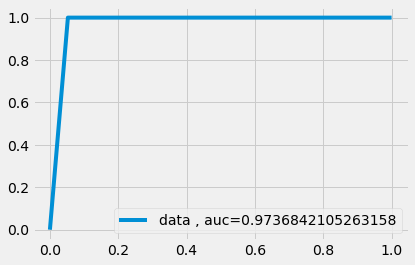

In [15]:
#the individual models are then trained to see how they perform.
l = classification(X, y, X_train, X_test, y_train, y_test)

print("Logistic Regression Report \n")
l.logistic_Regressing()

SVM Report 

took 0.02 seconds to train SVM Model
Accuracy:  0.97 

Precision:  1.0 

Recall:  0.94 

f1 score:  0.97 

Confusion Matrix is: 
 [[19  0]
 [ 1 15]] 

Cross validation score is:  0.99 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.94      0.97        16

    accuracy                           0.97        35
   macro avg       0.97      0.97      0.97        35
weighted avg       0.97      0.97      0.97        35
 



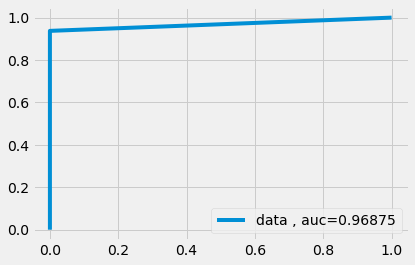

In [16]:
print("SVM Report \n")
l.SVM()

Light GBM Report 

took 0.45 seconds to train LightGBM Model
Accuracy:  0.97 

Precision:  0.94 

Recall:  1.0 

f1 score:  0.97 

Confusion Matrix is: 
 [[18  1]
 [ 0 16]] 

Cross validation score is:  0.99 

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.94      1.00      0.97        16

    accuracy                           0.97        35
   macro avg       0.97      0.97      0.97        35
weighted avg       0.97      0.97      0.97        35
 



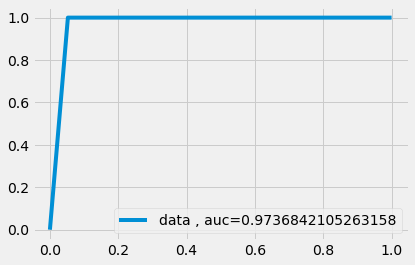

In [17]:
print("Light GBM Report \n")
l.LGBM()